<span style="font-size: 14pt">MIPT, Advanced ML, Autumn 2017</span>

<span style="font-size: 16pt"> HW #3: ARIMAX, Compositions

<span style="color:blue; font-size: 12pt">Alexey Romanenko </span>,
<span style="color:blue; font-size: 12pt; font-family: 'Verdana'">alexromsput@gmail.com</span>

**Дополнительный материал для выполнения дз**:
- Магнус Я.Р., Катышев П.К., Пересецкий А.А. Эконометрика. Начальный курс., глава 11
- Лукашин Ю.П. Адаптивные методы краткосрочного прогнозирования временных рядов. Финансы и статистика. 2003, главы 1,4,5,7.

**Оформление дз**: 
- Присылайте выполненное задание на почту ``ml.course.mipt@gmail.com``
- Укажите тему письма в следующем формате ``ML2017_Aut_fall <номер_группы> <фамилия>``, к примеру -- ``ML2017_Aut_fall 401 ivanov``
- Выполненное дз сохраните в файл ``<фамилия>_<группа>_task<номер>.ipnb``, к примеру -- ``ivanov_401_task1.ipnb``

**Вопросы**:
- Присылайте вопросы на почту ``ml.course.mipt@gmail.com``
- Укажите тему письма в следующем формате ``ML2017_Aut_fall Question <Содержание вопроса>``

<span style="color:red; font-size: 14pt;"> DEADLINE: 10 October 2017 23:59:59 </span>

--------
- **PS1**: Мы используем автоматические фильтры, и просто не найдем ваше дз, если вы не аккуратно его подпишите.
- **PS2**: Напоминаем, что дедлайны жесткие, письма пришедшие после автоматически удаляются =( чтобы соблазна не было 


<h1 align="center">Check Questions (20%)</h1> 

Ответе на вопросы своими словами (загугленный материал надо пересказать), ответ обоснуйте (напишите и ОБЪЯСНИТЕ формулки если потребуется), если не выходит, то вернитесь к лекции дополнительным материалам:

**Вопрос 1** Опишите ситуацию (аргументированно), в котором композиция Adaptive Selection будет прогнозировать хуже, чем лучший из базовых алгоритмов.

**Ответ:** В том случае, когда лучший из базовых алгоритмов выдает прогноз, который находится между правильным ответом и прогнозами всех остальных алгоритмов.

**Вопрос 2**  Опишите ситуацию (аргументированно), в котором композиция Adaptive Composition будет прогнозировать хуже, чем лучший из базовых алгоритмов.

**Ответ:** В том же случае.

**Вопрос 3** Что значит смешиваемость (mixability) игры (в теории агрегирующего алгоритма)?

**Ответ сложный и непонятный**

**Вопрос 4**: Верно ли, что для смешиваемых игр процесс потерь любой композиции (любого алгоритма) будет расти со временем (с ростом $t$) не быстрее, чем процесс потерь лучшего из базовых алгоритмов? Если нет - приведит пример, когда это не так.

### $$ \mathrm{Loss}_{Composition}(T)\leq \inf\limits_{BA} \mathrm{Loss}_{BA}(T)+C$$

**Хочу вопросы, в поисках ответов на которые можно узнать что-то новое, а не потратить впустую пару часов**

<h1 align="center">2. Contest: electricity comsumption contest (80%)</h1>
Take part in <a href='https://www.kaggle.com/t/de102b28cae74e6ead7492ff12efbc63'>contest</a>.
<span style='color:red'> You need to send the final code that is used for building forecast.</span>

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
from sklearn.preprocessing import MinMaxScaler
%matplotlib inline


from sklearn.metrics import mean_squared_error
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from sklearn.linear_model import LinearRegression

Using TensorFlow backend.


In [2]:
a = pd.DataFrame({"a": [1, 2], "b": [2, np.NaN]})
a

,a,b
0,1,2.0
1,2,NaN


In [3]:
a[1:2] + a[0:1]

,a,b
0,NaN,NaN
1,NaN,NaN


In [4]:
a.dropna()
a.index

RangeIndex(start=0, stop=2, step=1)

In [5]:
a.shift(-1)

a

,a,b
0,1,2.0
1,2,NaN


In [6]:
def prolong(a, l):
    return pd.concat([a] + [pd.DataFrame([[np.NaN for i in range(len(a.columns))]], columns=a.columns, 
                                         index=[j + 1 + a.index.max()]) for j in range(l)])
    
b = prolong(a, 10)
b

,a,b
0,1.0,2.0
1,2.0,NaN
2,NaN,NaN
3,NaN,NaN
4,NaN,NaN
5,NaN,NaN
6,NaN,NaN
7,NaN,NaN
8,NaN,NaN
9,NaN,NaN


In [7]:
b.loc[9:11, "b"] = [1, 2, 3]
b

,a,b
0,1.0,2.0
1,2.0,NaN
2,NaN,NaN
3,NaN,NaN
4,NaN,NaN
5,NaN,NaN
6,NaN,NaN
7,NaN,NaN
8,NaN,NaN
9,NaN,1.0


In [8]:
from collections import Counter

def weekday_define(s):
    c = Counter([d % 7 for d in s.index if s.loc[d, "Sunday"]])
    #print(c)
    for shift, count in c.items():
        if count > len(s) / 11:
            return shift
    return None
    

In [9]:

with open('./train.csv', 'r') as iofile:
    tsIN = pd.read_csv(iofile, sep=',', index_col=0)
    
final_forecast = pd.read_csv(open("SubmissionSample.csv", 'r'), sep=',', index_col=0)
    
tsIN.drop('Date', axis=1, inplace=True)

tsIN = tsIN[["tsID", "Temp", "Saturday", "Sunday", "ACTUAL"]]

tsIN.head()

,tsID,Temp,Saturday,Sunday,ACTUAL
ID,,,,,
1,4,-0.9,0.0,1,35489.95
2,4,-0.1,1.0,0,35413.59
3,4,-3.9,0.0,1,34802.67
4,4,-13.7,0.0,1,36003.84
5,4,-16.9,0.0,1,37622.96


In [10]:
def diff(a, h):
    a = a.copy()
    b = np.array(a[:-h])
    a[h:] = a[h:] - b
    return a

def undiff(a, h):
    a = a.copy()
    for i in range(h, len(a)):
        a[i:i + 1] = a[i:i + 1] + np.array(a[i - h:i - h + 1])
    return a
    

In [11]:
series = []
for i in set(tsIN["tsID"]):
    fr = pd.DataFrame(tsIN[tsIN["tsID"] == i]).copy()
    series.append(fr)
    scaler = MinMaxScaler()
    fr["Temp"] = scaler.fit_transform(fr[["Temp"]])
    fr.drop('tsID', axis=1, inplace=True)
    sunsh = weekday_define(fr)
    for weekday in range(0, 7):
        fr["weekday" + str(weekday)] = [1 if (j + 7 - sunsh) % 7 == weekday else 0 for j in range(len(fr))]
    fr.drop(['Sunday', "Saturday"], axis=1, inplace=True)
    assert(fr.index.max() - fr.index.min() + 1 == len(fr))
    plt.show()

In [12]:
series[0][:7]

,Temp,ACTUAL,weekday0,weekday1,weekday2,weekday3,weekday4,weekday5,weekday6
ID,,,,,,,,,
15672,0.902439,90468.0,0,0,0,0,0,0,1
15673,0.861789,92764.0,1,0,0,0,0,0,0
15674,0.878049,94791.0,0,1,0,0,0,0,0
15675,0.809756,98010.0,0,0,1,0,0,0,0
15676,0.848780,100975.0,0,0,0,1,0,0,0
15677,0.813008,103679.0,0,0,0,0,1,0,0
15678,0.822764,103584.0,0,0,0,0,0,1,0


In [13]:
s = series[10]
s["Temp"] = s["Temp"].fillna(np.mean(s["Temp"])) 
#s["Sunday"] = s["Sunday"].fillna(np.mean(s["Sunday"])) 
#s["Saturday"] = s["Saturday"].fillna(np.mean(s["Saturday"])) 
s["Temp"] = s["Temp"].fillna(np.mean(s["Temp"])) 
s.loc[:s.index[-32], "ACTUAL"] = s.loc[:s.index[-32], "ACTUAL"].fillna(np.mean(s.loc[:s.index[-32], "ACTUAL"])) 


In [14]:
len(s.loc[:s.index[-32], :].dropna())
#series[10].loc[s.index[-32]:, "ACTUAL"]

1034

In [15]:
series[0][:1]

,Temp,ACTUAL,weekday0,weekday1,weekday2,weekday3,weekday4,weekday5,weekday6
ID,,,,,,,,,
15672,0.902439,90468.0,0,0,0,0,0,0,1


In [16]:
def split_tvt(frame):
    tv = pd.DataFrame(frame[~np.isnan(frame["ACTUAL"])]).copy()
    k = int(len(tv) * 0.8)
    train = pd.DataFrame(tv.iloc[:k, :]).copy()
    validate = pd.DataFrame(tv.iloc[k:, :]).copy()
    test = pd.DataFrame(frame[np.isnan(frame["ACTUAL"])]).copy()
    
    t_scaler = MinMaxScaler()
    train["ACTUAL"] = t_scaler.fit_transform(train[["ACTUAL"]])
    
    tv_scaler = MinMaxScaler()
    tv["ACTUAL"] = tv_scaler.fit_transform(tv[["ACTUAL"]])
    
    return (train, validate, t_scaler), (tv, test, tv_scaler)
    
(train, validate, t_sc), (tv, test, tv_sc) = split_tvt(series[1])
print(len(train), len(validate), len(test))
tv

828 207 30


,Temp,ACTUAL,weekday0,weekday1,weekday2,weekday3,weekday4,weekday5,weekday6
ID,,,,,,,,,
17631,0.894389,0.396243,1,0,0,0,0,0,0
17632,0.927393,0.382971,0,1,0,0,0,0,0
17633,0.927393,0.412785,0,0,1,0,0,0,0
17634,0.828383,0.413394,0,0,0,1,0,0,0
17635,0.737624,0.428764,0,0,0,0,1,0,0
17636,0.762376,0.473113,0,0,0,0,0,1,0
17637,0.754125,0.490933,0,0,0,0,0,0,1
17638,0.844884,0.500589,1,0,0,0,0,0,0
17639,0.894389,0.494567,0,1,0,0,0,0,0


In [17]:
def series_to_supervised(data, backcols, back, y, yback, dropnan=True):
    df = pd.DataFrame(data)
    bf = df[backcols].copy()
    n_vars = df.values.shape[1]
    print('!', n_vars)
    y = pd.DataFrame(y)
    y = prolong(y, len(df) - len(y))
    cols, names = list(), list()
    # input sequence (t-n, ... t-1)
    
    cols.append(df)
    names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
    for i in back:
        cols.append(bf.shift(i))
        names += [('varb%d(t-%d)' % (j+1, i)) for j in range(len(backcols))]   
    for i in yback:
        names += ['y(t-%d)' % i,]
        cols.append(y.shift(i))
    
    # put it all together
    agg = pd.concat(cols, axis=1)
    agg.columns = names
    # drop rows with NaN values
    if dropnan:
        agg.dropna(inplace=True)
    return agg

In [18]:
class NeuralNetForecaster:
    
    def make_features(self, X, y, Xs):
        X = X.copy()
        y = y.copy()
        cX = pd.concat([X, Xs])
        features = series_to_supervised(cX, ["Temp"], [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 34, 35, 36
                                                      ], y, [30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42], False)
        return features[:len(X)], features[len(X):]
    
    def fit(self, X, y, verbose=1, label="???"):
        X = X.copy()
        y = y.copy()
        
        self.fitX = X.copy()
        self.fity = y.copy()
        
        X_train = X[:-30]
        y_train = y[:-30]
        X_test = X[-30:]
        y_test = y[-30:]
        
        X_train_features, X_test_features = self.make_features(X_train, y_train, X_test)
        #print(X_train_features[400:402])
        
        train_X = X_train_features.values
        train_X = train_X.reshape((train_X.shape[0], 1, train_X.shape[1]))
        train_y = y_train.values[:, 0]
        test_X = X_test_features.values
        test_X = test_X.reshape((test_X.shape[0], 1, test_X.shape[1]))
        test_y = y_test.values[:, 0]
        
        #print(test_X)
        
        if verbose:
            print(train_X.shape, train_y.shape, test_X.shape, test_y.shape)
        
        model = Sequential()
        self.model = model
        model.add(LSTM(300, input_shape=(train_X.shape[1], train_X.shape[2])))
        model.add(Dense(30, activation='sigmoid'))
        model.add(Dense(10))
        model.add(Dense(1, activation='sigmoid'))
        model.compile(loss='mae', optimizer='adam')
        
        print(len(train_X[408:]))
        history = model.fit(train_X[408:], train_y[408:], epochs=50, batch_size=70, validation_data=(test_X, test_y), 
                    verbose=verbose, shuffle=False)
    
        plt.plot(history.history['loss'], label='train')
        plt.plot(history.history['val_loss'], label='test')
        plt.title("History")
        plt.legend()
        plt.show()
        
        y["ACTUAL_PRED"] = [np.NaN for i in range(len(y))]
        
        y.loc[y.index[len(train_X)]:, "ACTUAL_PRED"] = model.predict(test_X).ravel()
        #print(y)
        plt.figure(figsize=(10, 10))
        y[['ACTUAL', 'ACTUAL_PRED']].plot()
        plt.xlim((y.index[int(len(y) * 0.8)], None))
        plt.ylim((-0.03, 0.03))
        plt.title(label)
        plt.legend()
        plt.show()
        
    def predict(self, X_test, label="??????"):
        assert(len(X_test) == len(X_test.dropna()))
        X_test = X_test.copy()
        X_train_features, X_test_features = self.make_features(self.fitX, self.fity, X_test)
        
        assert(len(X_test_features) == len(X_test_features.dropna()))
        
        test_X = X_test_features.values
        
        test_X = test_X.reshape((test_X.shape[0], 1, test_X.shape[1]))
        
        #print(self.fitX.shape, self.fity.shape, test_X.shape)
        
        y = self.fity.copy()
        y = prolong(y, len(X_test))
        #print(y.index)
        pred = self.model.predict(test_X).ravel()
        #print(pred)
        y.loc[y.index[len(self.fitX)]:, "ACTUAL_PRED"] = pred
        
        
        plt.figure(figsize=(10, 10))
        
        y[['ACTUAL', 'ACTUAL_PRED']].plot()
        plt.xlim((y.index[int(len(y) * 0.8)], None))
        plt.title(label)
        plt.legend()
        plt.show()
    
        return y

In [19]:
wdays = ["weekday" + str(i) for i in range(7)]
#nnf = NeuralNetForecaster()
#nnf.fit(tv[["Temp", "Saturday", "Sunday"]], tv[["ACTUAL"]], verbose=0)

In [20]:
#nnf.predict(test[["Temp", "Saturday", "Sunday"]])

In [21]:
tv = None
def serie_calc(s, label=""):
    (_, _, _), (tv, test, tv_sc) = split_tvt(s)
    tv['ACTUAL'] = diff(diff(tv['ACTUAL'], 364), 7)
    nnf = NeuralNetForecaster()
    #print(tv.index)
    #print(test.index)
    nnf.fit(tv[["Temp"] + wdays], tv[["ACTUAL"]], verbose=0, label=label + " FIT")
    ans = nnf.predict(test[["Temp"] + wdays], label=label + " PREDICT")
    ans = pd.DataFrame(ans[["ACTUAL_PRED"]]).dropna()
    ans.columns = ["ACTUAL"]
    
    ss = pd.concat([tv, test])
    ss.loc[ans.index, 'ACTUAL'] = ans
    ans['ACTUAL'] = undiff(undiff(ss['ACTUAL'], 7), 364)[-len(ans):]
    ans[["ACTUAL"]] = tv_sc.inverse_transform(ans[["ACTUAL"]])
    #print(ans["ACTUAL"])
    plt.figure(figsize=(10, 10))
    #ans.plot()
    #print(len(ans))
    s["ACTUAL_PRED"] = ans["ACTUAL"]
    s[["ACTUAL", "ACTUAL_PRED"]].plot()
    plt.xlim((s.index[int(len(s) * 0.6)], None))
    plt.title(label + " ORIGINAL")
    plt.show()
    return ans


In [22]:
#serie_calc(series[1], label="ZERO")


! 8
597


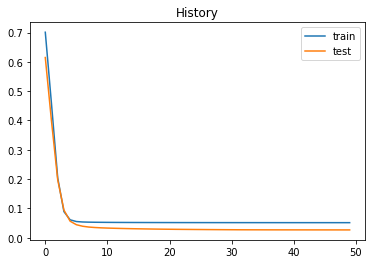

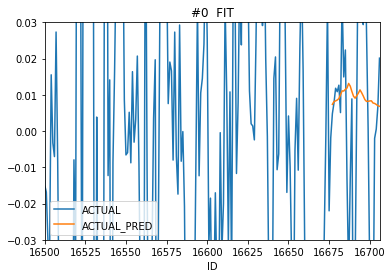

! 8


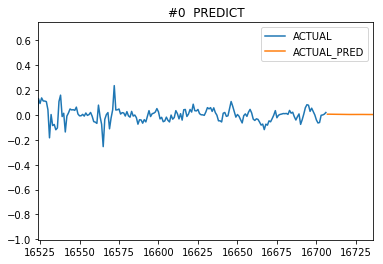

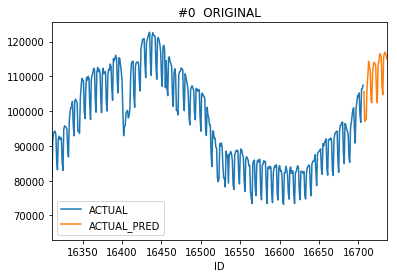

! 8
597


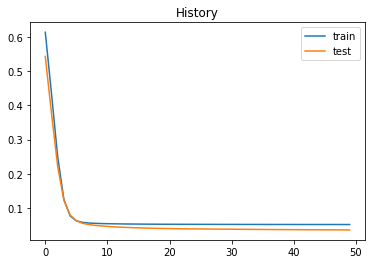

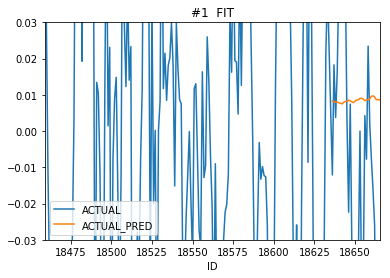

! 8


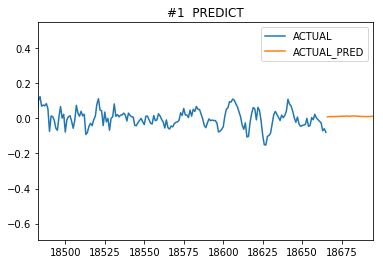

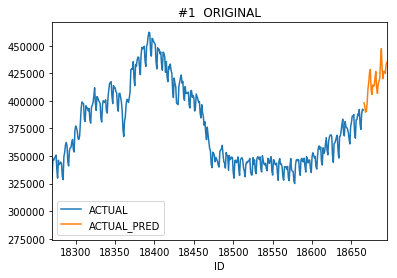

! 8
597


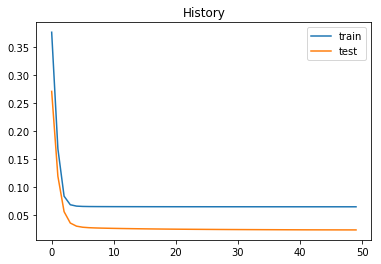

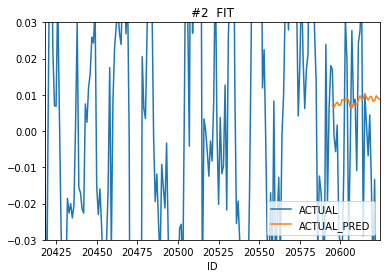

! 8


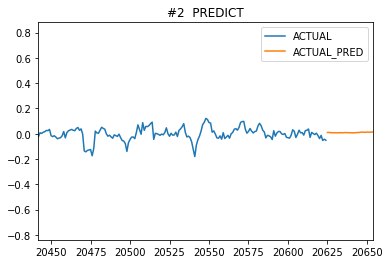

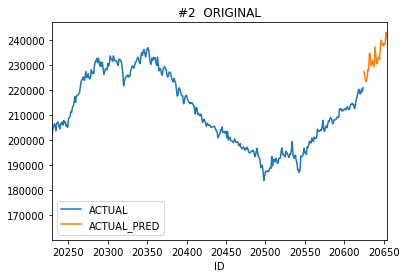

! 8
597


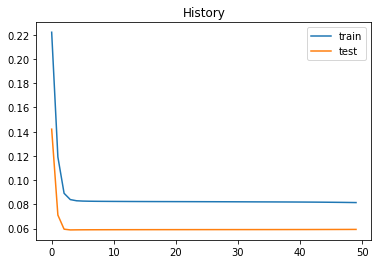

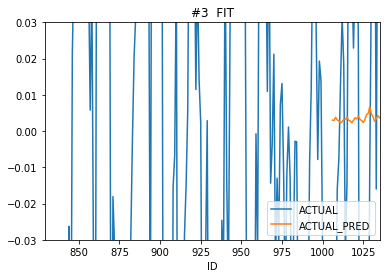

! 8


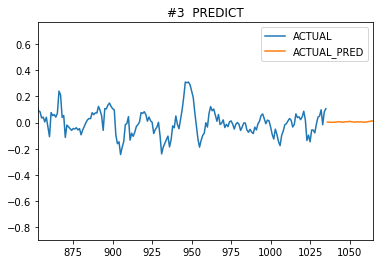

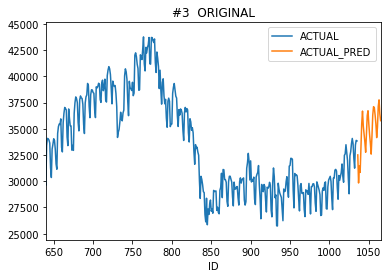

! 8
597


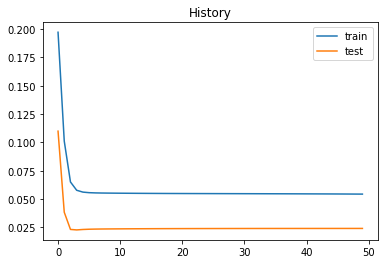

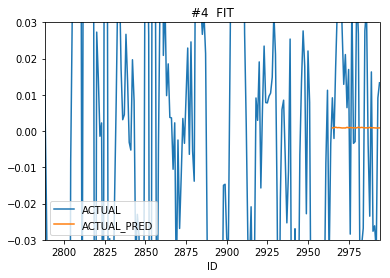

! 8


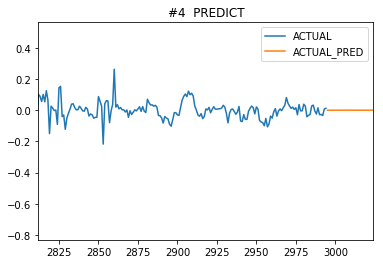

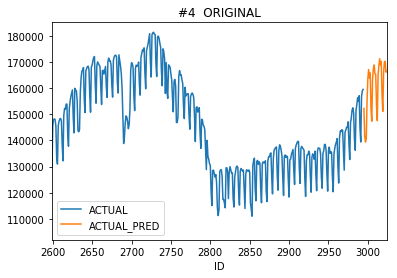

! 8
597


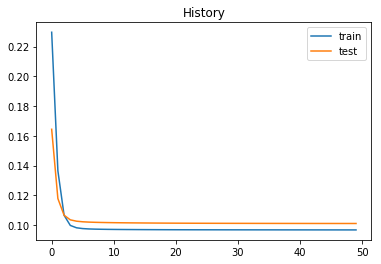

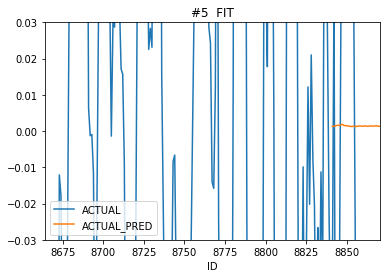

! 8


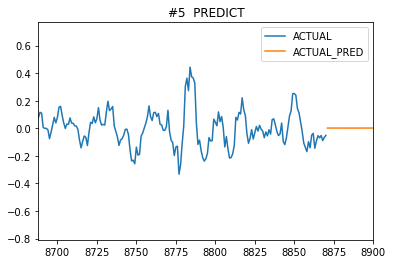

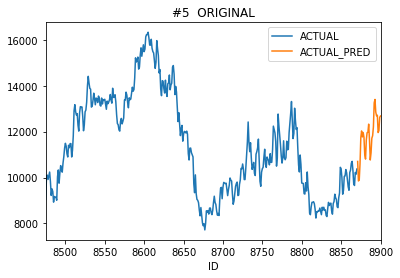

! 8
597


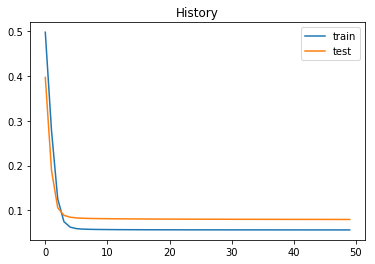

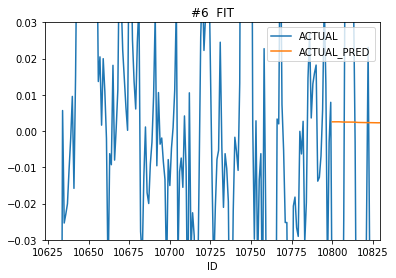

! 8


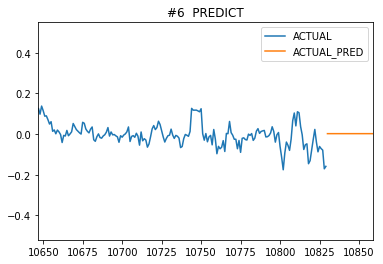

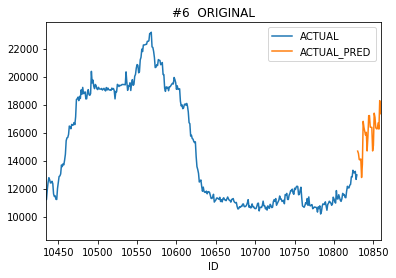

! 8
597


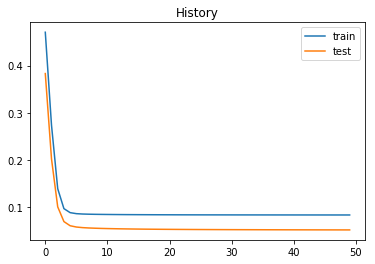

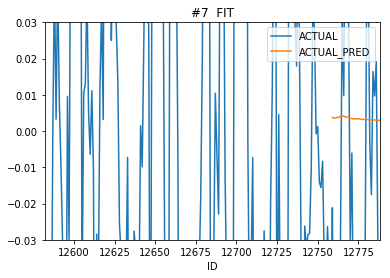

! 8


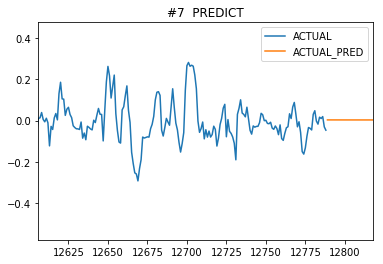

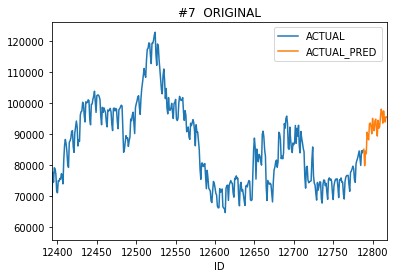

! 8
597


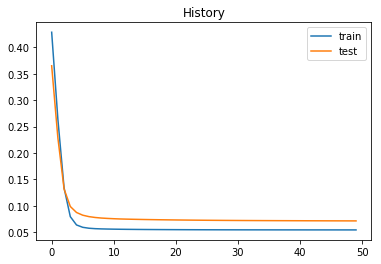

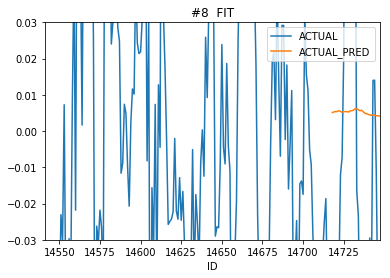

! 8


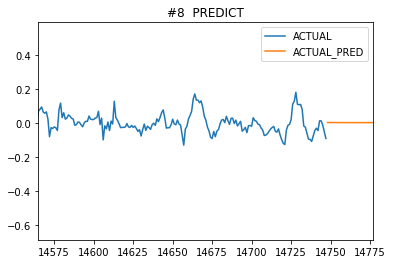

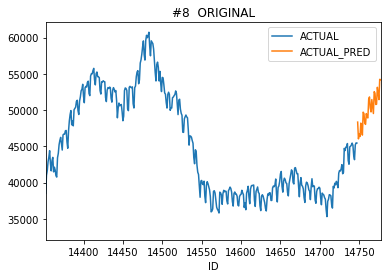

! 8
597


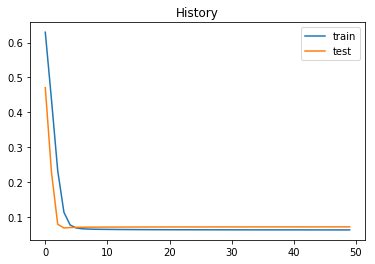

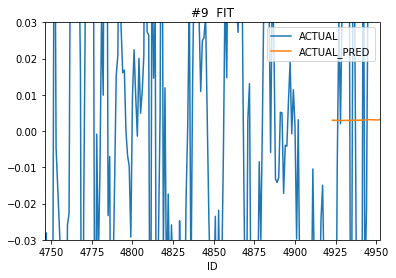

! 8


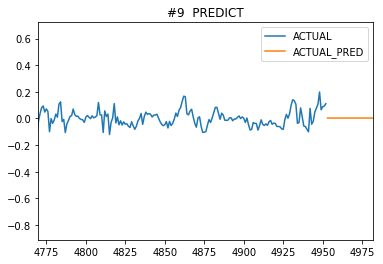

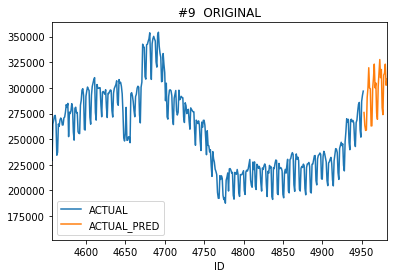

! 8
597


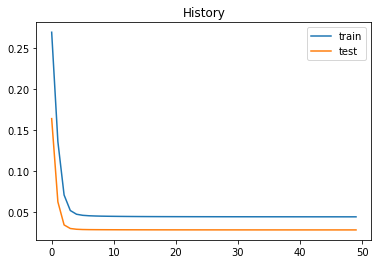

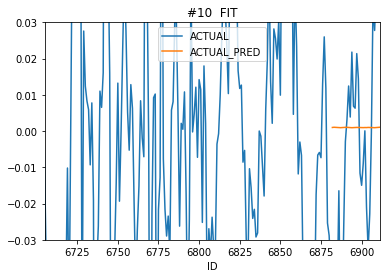

! 8


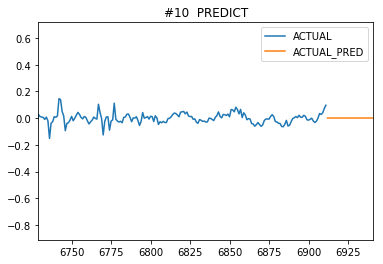

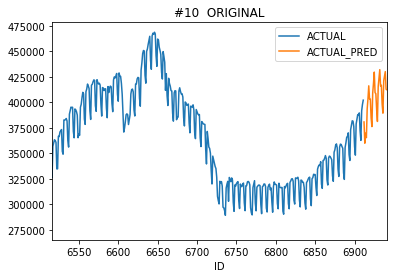

! 8
395


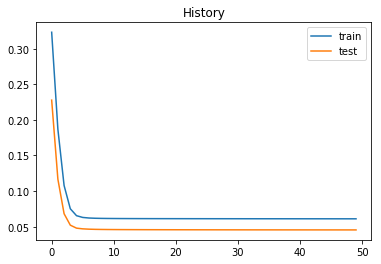

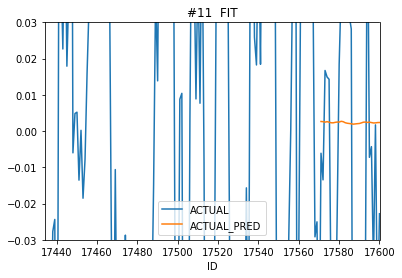

! 8


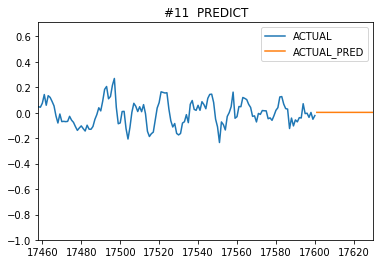

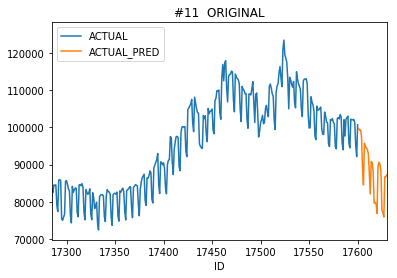

! 8
395


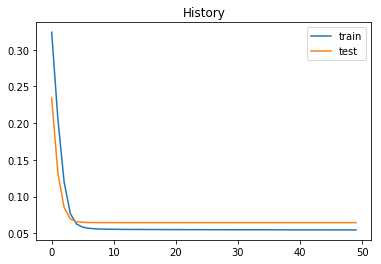

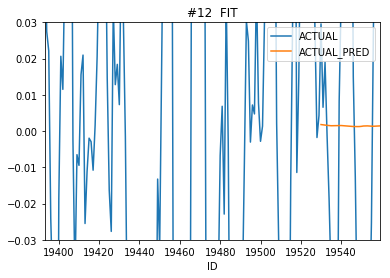

! 8


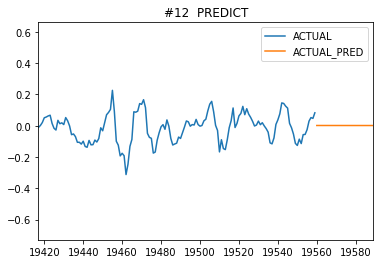

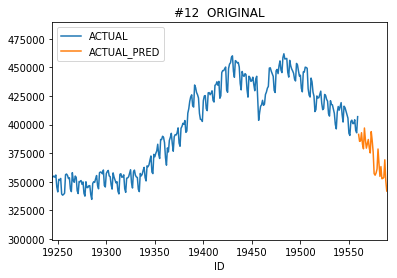

! 8
395


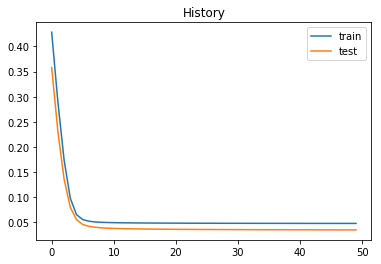

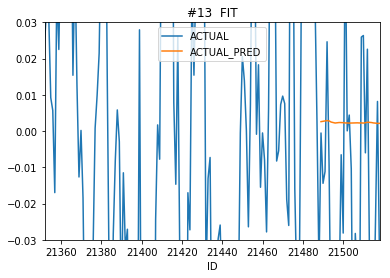

! 8


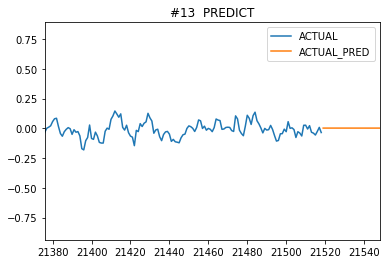

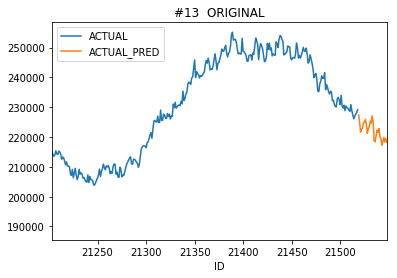

! 8
395


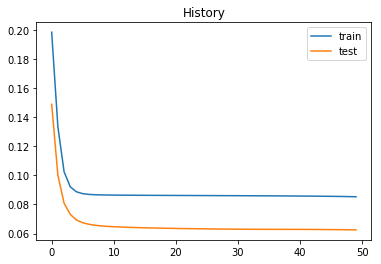

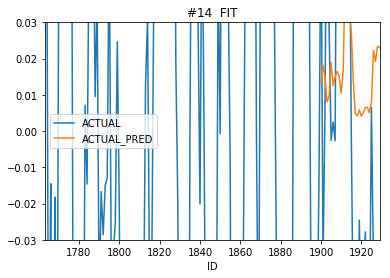

! 8


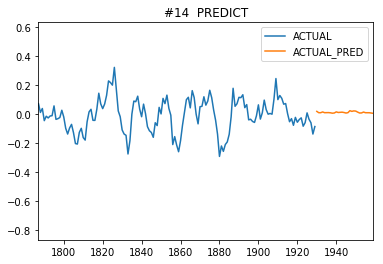

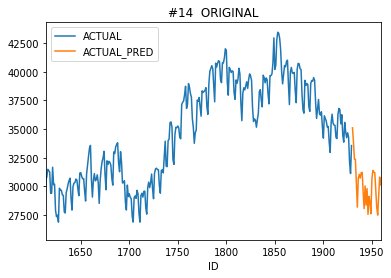

! 8
394


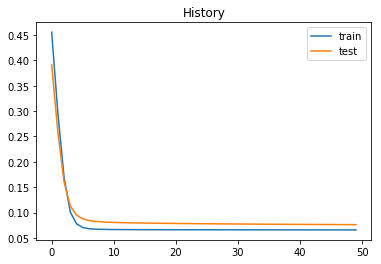

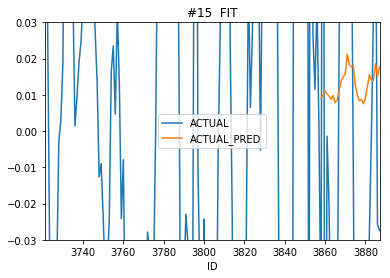

! 8


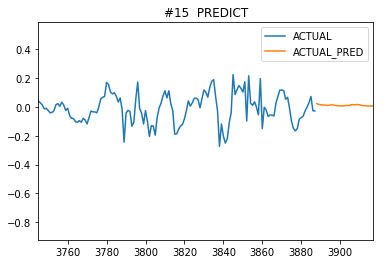

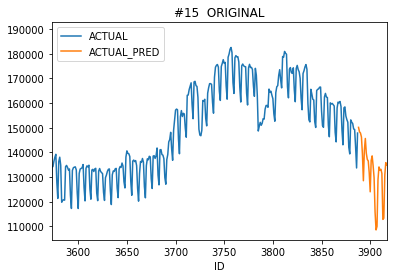

! 8
395


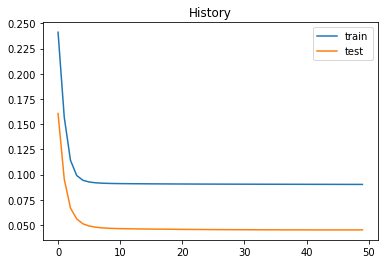

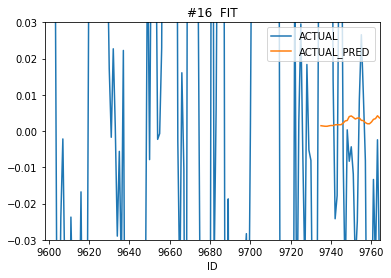

! 8


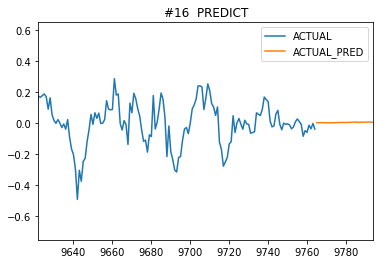

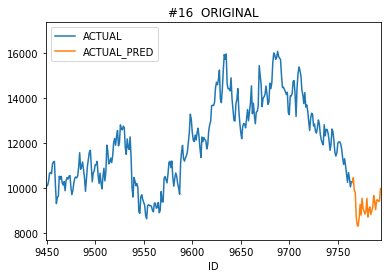

! 8
395


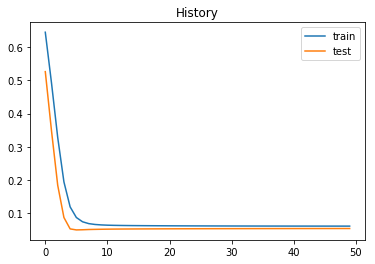

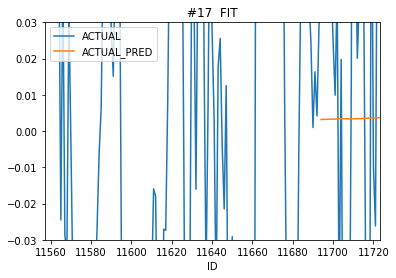

! 8


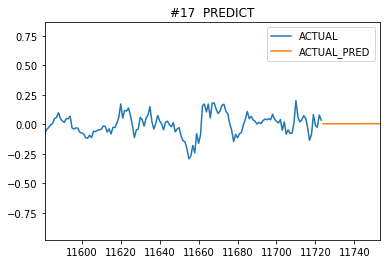

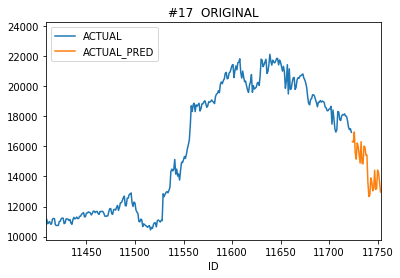

! 8
395


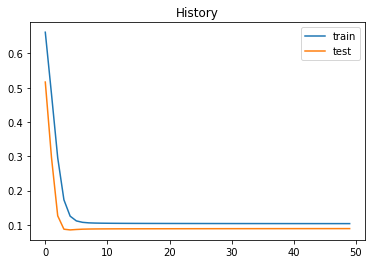

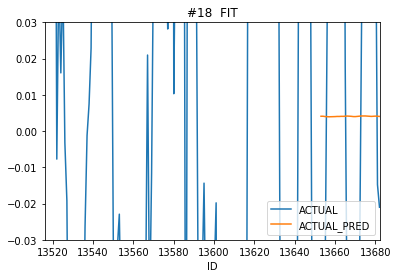

! 8


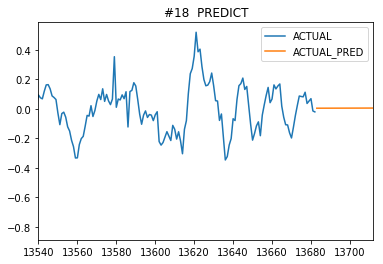

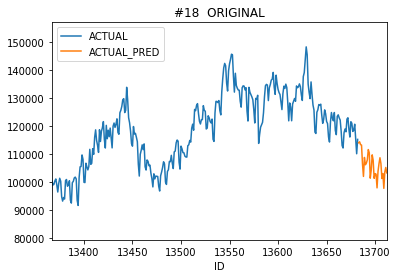

! 8
395


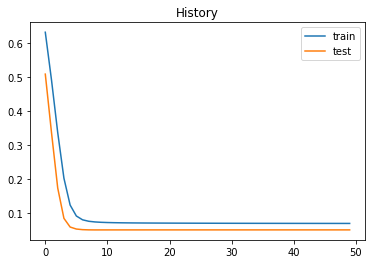

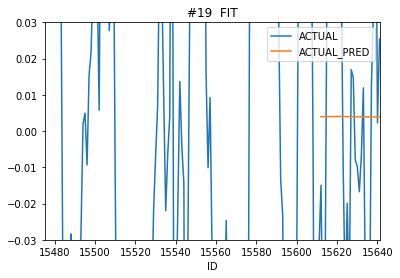

! 8


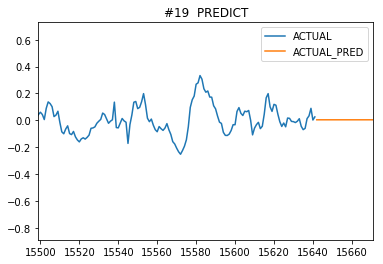

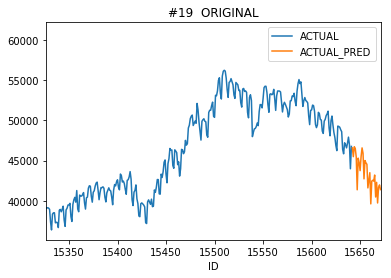

! 8
395


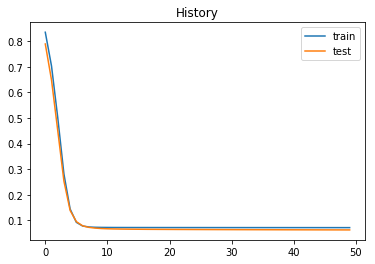

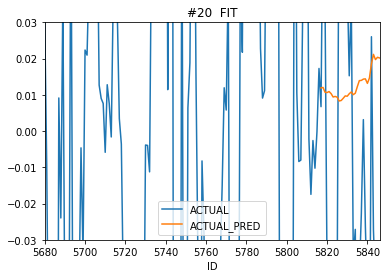

! 8


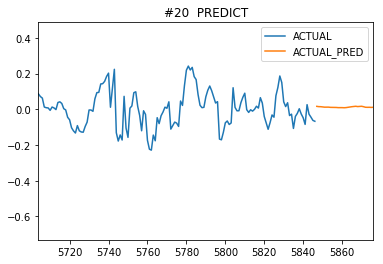

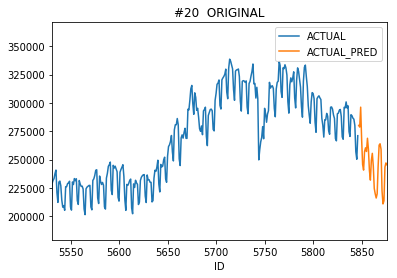

! 8
395


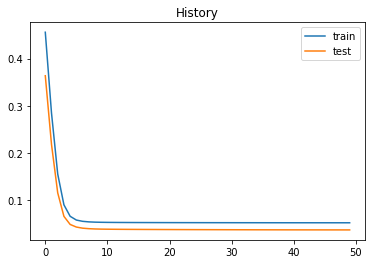

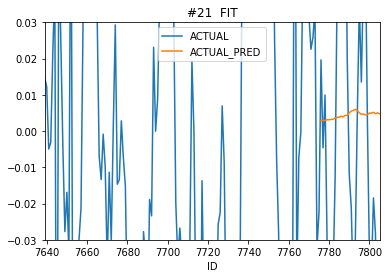

! 8


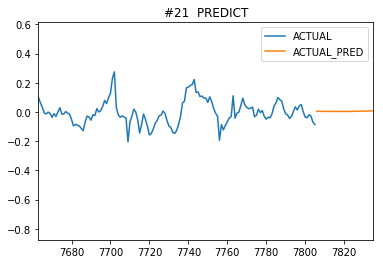

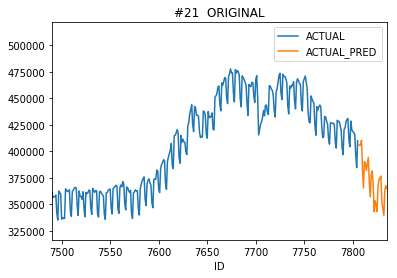

In [23]:
for i, s in list(enumerate(series))[:]:
    try:
        ans = serie_calc(s, label='#' + str(i) + " ").dropna()
        for j in ans.index:
            final_forecast.loc[j, "PREDICTED"] = ans.loc[j, "ACTUAL"]
    except:
        print("FAILED " + str(i))
        raise
        pass

In [24]:
len(final_forecast.dropna())

660

In [25]:
len(final_forecast)

660

In [26]:
# save forecast to disk for further submission
final_forecast.to_csv('result.csv')